In [5]:
!pip install gensim
!python -m spacy download en_core_web_lg

# importing library

In [30]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import pandas as p
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
wv = api.load('word2vec-google-news-300')
nlp = spacy.load("en_core_web_lg")

# Dataset

In [9]:
msg=pd.read_csv('/content/sample_data/SMSSpamCollection.txt',
                    sep='\t',names=["label","message"])

In [10]:
msg.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
msg.shape

(5572, 2)

In [12]:
#check the distribution of labels
msg['label'].value_counts()

,count
label,
ham,4825
spam,747


# Underasampling

In [13]:
min_samples = 747 # we have these many SCIENCE articles and SCIENCE is our minority class
msg_ham = msg[msg.label=="ham"].sample(min_samples, random_state=2022)
msg_spam = msg[msg.label=="spam"]

msg_balanced = pd.concat([msg_ham,msg_spam],axis=0)
msg_balanced.label.value_counts()

,count
label,
ham,747
spam,747


In [14]:
#Add the new column which gives a unique number to each of these labels

msg['label_num'] = msg['label'].map({'ham' : 0, 'spam': 1})

#check the results with top 5 rows
msg.head(5)

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Function For Preprocessing Data

In [20]:
def preprocess_and_vectorize(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    # Handle empty filtered_tokens
    if not filtered_tokens:
        # Return a zero vector of the appropriate dimension
        return np.zeros(wv.vector_size)
    else:
        return wv.get_mean_vector(filtered_tokens)

In [21]:
msg['vector'] = msg['message'].apply(lambda text: preprocess_and_vectorize(text))

In [22]:
msg.head()

,label,message,label_num,vector
0,ham,"Go until jurong point, crazy.. Available only ...",0,"[-0.0041043647, 0.0099556185, 0.0025464045, 0...."
1,ham,Ok lar... Joking wif u oni...,0,"[-0.03199796, 0.023136022, 0.016629472, 0.0432..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[0.0008006294, -0.024787553, -0.02796412, 0.01..."
3,ham,U dun say so early hor... U c already then say...,0,"[-0.03189813, 0.04080349, 0.05570483, 0.044774..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"[-0.022122253, 0.01797974, 0.013089311, 0.0959..."


# Train n Test

In [23]:
#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    msg.vector.values,
    msg.label_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=msg.label_num)

# Reshaping the X_train and X_test so as to fit for models

In [25]:
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)

X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (4457,)
Shape of X_test before reshaping:  (1115,)
Shape of X_train after reshaping:  (4457, 300)
Shape of X_test after reshaping:  (1115, 300)


# Train Machine Learning Model

## GradientBoosting

In [26]:
#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



## Decision Tree Classifier

In [29]:
# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier()

# Fit the model
dt_clf.fit(X_train_2d, y_train)

# Make predictions
dt_y_pred = dt_clf.predict(X_test_2d)

# Evaluate the model
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       966
           1       0.64      0.75      0.69       149

    accuracy                           0.91      1115
   macro avg       0.80      0.84      0.82      1115
weighted avg       0.92      0.91      0.91      1115



## Random Forest Classifier

In [40]:
# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier()

# Fit the model
rf_clf.fit(X_train_2d, y_train)

# Make predictions
rf_y_pred = rf_clf.predict(X_test_2d)

# Evaluate the model
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.75      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



# Make some predictions

In [33]:
test = ["I'm going to the grocery store later, do you need anything?",  #ham
        "Congratulations! You've won a free prize. Claim it now by clicking the link below.",  # Spam
        "How are you doing today? Hope everything is going well."]      #ham

In [34]:
test_vectors = [preprocess_and_vectorize(n) for n in test]
clf.predict(test_vectors)

array([0, 1, 0])

 'ham' : 0, 'spam': 1

Text(95.72222222222221, 0.5, 'Truth')

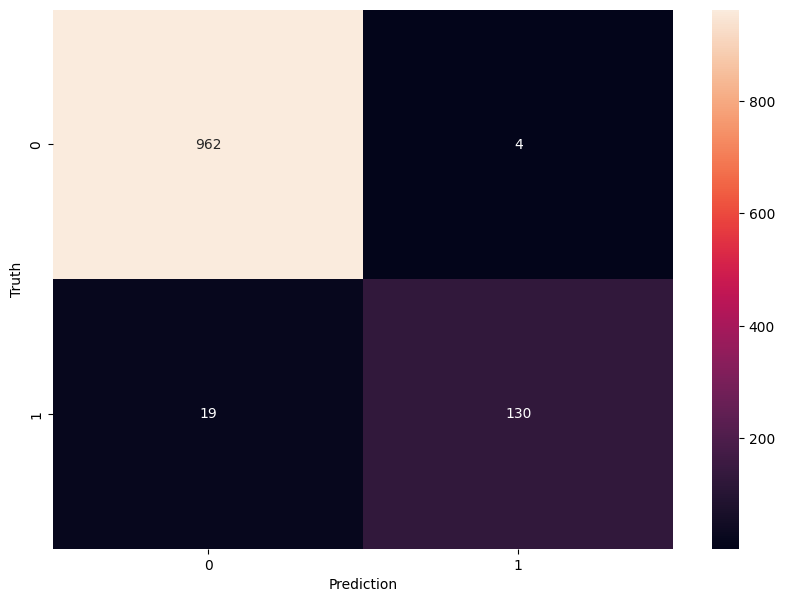

In [35]:
#finally print the confusion matrix for the best model (GradientBoostingClassifier)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')